In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy

from dataloaders import *
from util import Config
from viz_utils import *

## Load experiments

In [3]:
datasets = ["MRPC", "TREC-2", "SUBJ", "AGN-2", "TREC-6", "AGN-4", "SST"]
load_anti = False
n = 0  # AL step at which evaluation (AUC) starts
model = "BERT"
mode = "ada"
dataset = "SUBJ"

aucs = []
trs = []
try:
    experiments = load_dataset_results(
        base_dir=f"results/SUBJ",
        dataset=dataset,
        model=model,
    )
except:
    print(f"No experiments for {dataset}-{model}-{mode}")
    
for (exp, meta) in experiments:
    for load_mode in ["last", "best"]:
        df_tr_i = experiment_to_df(exp, mode=load_mode)

        df_tr_i["model"] = meta["model"]
        df_tr_i["mode"] = load_mode
        df_tr_i["dataset"] = dataset
        df_tr_i["tapta"] = meta["tapta"]
        df_tr_i["sampler"] = meta["sampler"]
        df_tr_i["adapter"] = meta["adapter"]
        df_tr_i = df_tr_i.reset_index().set_index(
            ["dataset", "model", "adapter", "tapta", "mode", "sampler", "experiment", "al_iter"]
        )
        trs.append(df_tr_i)

        df_auc_i = al_auc(df_tr_i)
        df_auc_i["mode"] = load_mode
        df_auc_i = df_auc_i.reset_index().set_index(["mode", "sampler"])
        aucs.append(df_auc_i)


df_tr = pd.concat(trs)
df_auc = pd.concat(aucs)

SUBJ-BERT
Loaded: SUBJ-BERT-prefix-tapta=False-random
Loaded: SUBJ-BERT-prefix-tapta=True-random
Loaded: SUBJ-BERT-unipelt-tapta=False-core_set
Loaded: SUBJ-BERT-prefix-tapta=True-entropy
Loaded: SUBJ-BERT-fft-tapta=True-entropy
Loaded: SUBJ-BERT-unipelt-tapta=True-entropy_dropout
Loaded: SUBJ-BERT-lora-tapta=True-entropy_dropout
Loaded: SUBJ-BERT-prefix-tapta=True-entropy_dropout
Loaded: SUBJ-BERT-lora-tapta=False-entropy_dropout
Loaded: SUBJ-BERT-unipelt-tapta=True-dal
Loaded: SUBJ-BERT-unipelt-tapta=True-entropy
Loaded: SUBJ-BERT-prefix-tapta=False-dal
Loaded: SUBJ-BERT-fft-tapta=False-core_set
Loaded: SUBJ-BERT-lora-tapta=True-core_set
Loaded: SUBJ-BERT-lora-tapta=False-random
Loaded: SUBJ-BERT-houlsby-tapta=False-entropy
Loaded: SUBJ-BERT-unipelt-tapta=True-random
Loaded: SUBJ-BERT-houlsby-tapta=True-entropy
Loaded: SUBJ-BERT-lora-tapta=True-dal
Loaded: SUBJ-BERT-houlsby-tapta=True-random
Loaded: SUBJ-BERT-lora-tapta=True-entropy
Loaded: SUBJ-BERT-lora-tapta=False-core_set
Loaded:

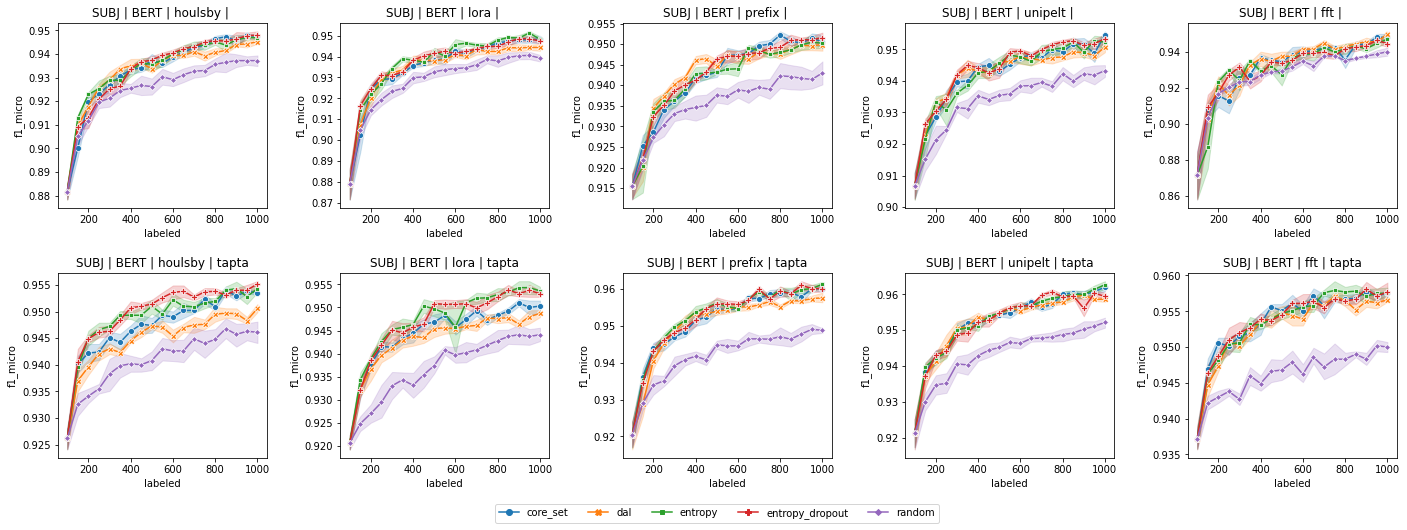

In [4]:
from itertools import product

metric = "f1_micro"
ci = 75

adapters = ["houlsby", "lora", "prefix", "unipelt", "fft"]
taptas = [False, True]
fig, axes = plt.subplots(2, 5, figsize=(24, 8))
axes = axes.ravel()
plt.subplots_adjust(hspace=0.35, wspace=0.35)

for i, (tapta, adapter) in enumerate(product(taptas, adapters)):
    f1 = df_tr.index.get_level_values("mode") == "best"
    f2 = df_tr.index.get_level_values("tapta") == tapta
    f3 = df_tr.index.get_level_values("adapter") == adapter
    g = sns.lineplot(
        ax=axes[i],
        data=df_tr[f1 & f2 & f3].sort_values("sampler"),
        x="labeled",
        y=metric,
        hue="sampler",
        style="sampler",
        markers=True,
        dashes=False,
        ci=ci,
    )
    g.set_title(f"{dataset} | {model} | {adapter} | {'tapta' if tapta else ''}")
    axes[i].get_legend().remove()
    if i == len(axes) - 1:
        handles, labels = axes[i].get_legend_handles_labels()
        g.legend(handles, labels)
        g.legend(loc="center", bbox_to_anchor=(-2.25, -0.3), ncol=5)
        
    

## Representation analysis

In [42]:
from models import *
from args import *
from dataloaders import *
from transformers import AutoTokenizer, BertModel

args = Config()
args.lr = 2e-5
args.l2 = 0
args.model = "BERT"
args.data = "SUBJ"
args.adapter = None
args.batch_size = 32
args.epochs = 10
args.clip = 1

meta = Config()

dataloader = dataset_loaders[args.data]
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMERS[args.model])
(train, val, test) = dataloader(meta=meta, tokenizer=tokenizer)

if args.data in pair_sequence_datasets:
    meta.pair_sequence = True
else:
    meta.pair_sequence = False
    
meta.task_type = "clf"

if meta.num_labels == 2:
    # Binary classification
    criterion = nn.BCEWithLogitsLoss()
    meta.num_targets = 1
else:
    # Multiclass classification
    criterion = nn.CrossEntropyLoss()
    meta.num_targets = meta.num_labels
    


device = torch.device("cuda:0")

In [43]:
df = df_tr[
    (df_tr.index.get_level_values("sampler") == "entropy")
    & (df_tr.index.get_level_values("mode") == "best")
    & (df_tr.index.get_level_values("experiment") == 0)
]
selected = df.selected.agg(list)
sel = [s for ss in selected for s in ss]
indices = np.array(sel)



In [44]:


base_model = BertModel.from_pretrained(TRANSFORMERS[args.model])
base_model.to(device)

BertModel(
  (shared_parameters): ModuleDict()
  (invertible_adapters): ModuleDict()
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(
              in_features=768, out_features=768, bias=True
              (loras): ModuleDict()
            )
            (key): Linear(
              in_features=768, out_features=768, bias=True
              (loras): ModuleDict()
            )
            (value): Linear(
              in_features=768, out_features=768, bias=True
              (loras): ModuleDict()
            )
            (dropout): Dropout(p=0.1, inplace=False

In [45]:
import time
from al.experiment import Experiment


def train_model(model, optimizer, criterion, train_iter):
    model.train()

    total_loss = 0.0
    accuracy, confusion_matrix = 0, np.zeros(
        (meta.num_labels, meta.num_labels), dtype=int
    )

    logit_list = []
    y_true_list = []
    ids = []
    for batch_num, batch in enumerate(train_iter, 1):
        t = time.time()

        optimizer.zero_grad()

        ids.extend([id for id in batch.id])

        # Unpack batch & cast to device
        if meta.pair_sequence:
            (x_sequence1, sequence1_lengths) = batch.sequence1
            (x_sequence2, sequence2_lengths) = batch.sequence2
        else:
            x = batch.text

        y = batch.label
        y_true_list.append(y.squeeze(0) if y.numel() == 1 else y.squeeze())

        if meta.pair_sequence:
            # PSQ
            lengths = (sequence1_lengths, sequence2_lengths)
            output, return_dict = model(x_sequence1, x_sequence2, lengths)
            logits = output.logits
        else:
            # SSQ
            output, return_dict = model(x)
            logits = output.logits
        logit_list.append(logits)

        # Bookkeeping and cast label to float
        accuracy, confusion_matrix = Experiment.update_stats(
            accuracy, confusion_matrix, logits, y
        )
        if logits.shape[-1] == 1:
            # binary cross entropy, cast labels to float
            y = y.type(torch.float)

        loss = criterion(logits.view(-1, meta.num_targets).squeeze(), y.squeeze())

        total_loss += float(loss)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()

        print(
            "[Batch]: {}/{} in {:.5f} seconds".format(
                batch_num, len(train_iter), time.time() - t
            ),
            end="\r",
            flush=True,
        )

    loss = total_loss / len(train_iter)
    result_dict = {"loss": loss}
    logit_tensor = torch.cat(logit_list)
    y_true = torch.cat(y_true_list)
    return result_dict, logit_tensor, y_true, ids

def evaluate_model(model, tokenizer, data):
        model.eval()

        accuracy, confusion_matrix = 0, np.zeros(
            (6, 6), dtype=int
        )

        logit_list = []
        y_true_list = []
        with torch.inference_mode():
            for batch_num, batch in enumerate(data):

                t = time.time()

                # Unpack batch & cast to device
                x = batch.text

                y = batch.label
                y = y.squeeze()  # y needs to be a 1D tensor for xent(batch_size)

                y_true_list.append(y.cpu())

                output, _ = model(
                    x,
                )
                loss, logits = output.loss, output.logits

                logit_list.append(logits.cpu())

                # Bookkeeping and cast label to float
                accuracy, confusion_matrix = Experiment.update_stats(
                    accuracy, confusion_matrix, logits, y
                )

                print(
                    "[Batch]: {}/{} in {:.5f} seconds".format(
                        batch_num, len(data), time.time() - t
                    ),
                    end="\r",
                    flush=True,
                )

        logit_tensor = torch.cat(logit_list)
        y_true = torch.cat(y_true_list)
        probs = logits_to_probs(logit_tensor)
        y_pred = torch.argmax(probs, dim=1).numpy()
        f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
        f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average="macro")

        print(
            "[Accuracy]: {}/{} : {:.3f}%".format(
                accuracy,
                len(test),
                accuracy / len(test) * 100,
            )
        )
        print(f"[F1-micro]: {f1_micro:.3f}")
        print(f"[F1-macro]: {f1_macro:.3f}")
        print(confusion_matrix)

        result_dict = {
            "accuracy": accuracy / len(test),
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
        }

        return result_dict, probs, y_true

In [46]:
test_iter = make_iterable(
    test,
    device,
    batch_size=args.batch_size,
    shuffle=False,
)

In [47]:
from util import logits_to_probs
from sklearn.metrics import f1_score


train_results = []
for epoch in range(1, args.epochs + 1):
    print(f"Training epoch: {epoch}/{args.epochs}")
    # a) Train for one epoch
    result_dict_train, logits, y_true, ids = train_model(
        model, optimizer, criterion, train_iter
    )
    print(result_dict_train)
    eval_result_dict = evaluate_model(model=model, tokenizer=tokenizer, data=test_iter)
    print(eval_result_dict)
    train_results.append(result_dict_train)

Training epoch: 1/10
{'loss': 0.35004495255672896}econds
[Accuracy]: 1897/2000 : 94.850%ds
[F1-micro]: 0.949
[F1-macro]: 0.948
[[904  66   0   0   0   0]
 [ 37 993   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]
({'accuracy': 0.9485, 'f1_micro': 0.9485, 'f1_macro': 0.9483978147727037}, tensor([[0.0062, 0.9938],
        [0.9921, 0.0079],
        [0.0081, 0.9919],
        ...,
        [0.9910, 0.0090],
        [0.9924, 0.0076],
        [0.9902, 0.0098]]), tensor([1, 0, 1,  ..., 0, 0, 0]))
Training epoch: 2/10
{'loss': 0.04629654256580844}econds
[Accuracy]: 1868/2000 : 93.400%ds
[F1-micro]: 0.934
[F1-macro]: 0.934
[[954  16   0   0   0   0]
 [116 914   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]
({'accuracy': 0.934, 'f1_micro': 0.934, 'f1_macro': 0.9339735894357744}, tensor([[9.9570e-04, 9.9900e-01],
        [9.9759e-01, 2.4095e-03],

In [54]:
test_sample = make_iterable(
    test,
    device,
    batch_size=args.batch_size,
    shuffle=False,
    indices=range(100)
)


def model_repr(model, test_sample):
    model.eval()
    name = model.get_classifier_name()
    clf = model.classifier
    config = model.classifier.config
    num_layers = config.num_hidden_layers

    enc = []
    grads = []
    labels = []
    enc_layers = {i: [] for i in range(num_layers)}

    with torch.inference_mode():
        for batch in test_sample:
            inputs = batch.text
            labels.append(batch.label)
            inputs.requires_grad = False

            encoded_all = clf(
                inputs,
                output_hidden_states=True,
            )
            # Skip the embedding layer [1:]
            for i, enc_layer in enumerate(encoded_all[1][1:]):
                enc_layers[i].append(enc_layer[:, 0].cpu())


            encoded = encoded_all[0][:, 0]
            enc.append(encoded.cpu())

            torch.cuda.empty_cache()

        y = torch.cat(labels)
        for k, v in enc_layers.items():
            X = torch.cat(v)
            enc_layers[k] = X
    return enc_layers
            
            

def base_model_repr(base_model, test_sample):
    base_model.eval()
    clf = base_model
    config = base_model.config
    num_layers = config.num_hidden_layers
    enc = []
    grads = []
    labels = []
    enc_layers2 = {i: [] for i in range(num_layers)}




    with torch.inference_mode():
        for batch in test_sample:

            inputs = batch.text
            labels.append(batch.label)
            inputs.requires_grad = False

            output = clf(
                inputs,
                output_hidden_states=True,
            )
            # Skip the embedding layer [1:]
            encoded_all = output.hidden_states
            for i, enc_layer in enumerate(encoded_all[1:]):
                enc_layers2[i].append(enc_layer[:, 0].cpu())

            torch.cuda.empty_cache()

        y = torch.cat(labels)
        for k, v in enc_layers2.items():
            X = torch.cat(v)
            enc_layers2[k] = X
            
    return enc_layers2

In [133]:
from cka import *

lins = []
rbfs = []

for train_size in range(150, 1000+50, 50):
    train_iter = make_iterable(
        train,
        device,
        batch_size=args.batch_size,
        shuffle=True,
        indices=indices[:train_size]
    )
    
    model = Transformer(args, meta, args.model, pretrained=None, adapter=None)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.l2)
    
    for epoch in range(1, args.epochs + 1):
        print(f"Training epoch: {epoch}/{args.epochs}")
        # a) Train for one epoch
        result_dict_train, logits, y_true, ids = train_model(
            model, optimizer, criterion, train_iter
        )
        print(result_dict_train)
#         eval_result_dict = evaluate_model(model=model, tokenizer=tokenizer, data=test_iter)
#         print(eval_result_dict)
        train_results.append(result_dict_train)
    enc_layers = model_repr(model, test_sample)

    n = 12

    lin_vals = np.empty((n, n))
    rbf_vals = np.empty((n, n))

    enc_layers = model_repr(model, test_sample)
    enc_layers2 = base_model_repr(base_model, test_sample)

    for i in range(12):
        enc1 = enc_layers[i].detach().cpu().numpy()
        for j in range(i, 12):
            enc2 = enc_layers2[j].detach().cpu().numpy()
            lin = linear_CKA(enc1, enc2)
            rbf = kernel_CKA(enc1, enc2)
            lin_vals[i, j] = lin_vals[j, i] = lin
            rbf_vals[i, j] = rbf_vals[j, i] = rbf
        print(f"{i} finished")
    lins.append(lin_vals)
    rbfs.append(rbf_vals)

Training epoch: 1/10
{'loss': 0.6905459523200989}nds
Training epoch: 2/10
{'loss': 0.6715219497680665}nds
Training epoch: 3/10
{'loss': 0.6571648359298706}nds
Training epoch: 4/10
{'loss': 0.6323144912719727}nds
Training epoch: 5/10
{'loss': 0.5857851505279541}nds
Training epoch: 6/10
{'loss': 0.5342566490173339}nds
Training epoch: 7/10
{'loss': 0.4524990916252136}nds
Training epoch: 8/10
{'loss': 0.3799178421497345}nds
Training epoch: 9/10
{'loss': 0.29581228494644163}ds
Training epoch: 10/10
{'loss': 0.2416124790906906}nds
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
Training epoch: 1/10
{'loss': 0.6935976147651672}nds
Training epoch: 2/10
{'loss': 0.6919240610940116}nds
Training epoch: 3/10
{'loss': 0.6735800164086478}nds
Training epoch: 4/10
{'loss': 0.6756959557533264}nds
Training epoch: 5/10
{'loss': 0.5981216515813556}nds
Training epoch: 6/10
{'loss': 0.4885454901627132}nds
Training epoch: 7

{'loss': 0.6837305501103401}conds
Training epoch: 2/10
{'loss': 0.6742237135767937}conds
Training epoch: 3/10
{'loss': 0.6770007560650507}conds
Training epoch: 4/10
{'loss': 0.6745495572686195}conds
Training epoch: 5/10
{'loss': 0.6633066187302271}conds
Training epoch: 6/10
{'loss': 0.6281811197598776}conds
Training epoch: 7/10
{'loss': 0.5079748642941316}conds
Training epoch: 8/10
{'loss': 0.37074878128866356}onds
Training epoch: 9/10
{'loss': 0.26733951549977064}onds
Training epoch: 10/10
{'loss': 0.16676124930381775}onds
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
Training epoch: 1/10
{'loss': 0.6848055863380432}conds
Training epoch: 2/10
{'loss': 0.6664967036247254}conds
Training epoch: 3/10
{'loss': 0.6043700814247132}conds
Training epoch: 4/10
{'loss': 0.4840042853355408}conds
Training epoch: 5/10
{'loss': 0.291436402797699}econds
Training epoch: 6/10
{'loss': 0.1853442147374153}conds
Traini

In [122]:
rbfs[10] = np.zeros((12, 12))

In [128]:
rbfs[10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

<IPython.core.display.Javascript object>


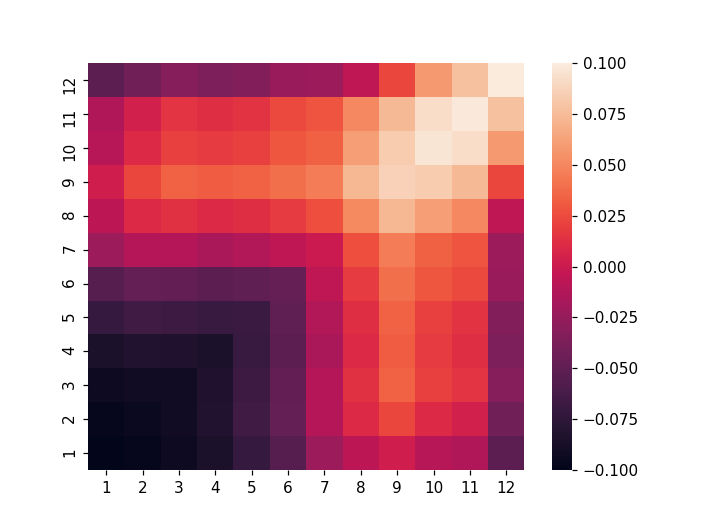

In [156]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()

sns.heatmap(np.zeros((12, 12)))

def init():
    sns.heatmap(np.flip(rbfs[0], 1), xticklabels=range(1, n+1), yticklabels=range(n, 0, -1), cbar=False)

def animate(frame_num):
    sns.heatmap(np.flip(rbfs[frame_num], 1),  xticklabels=range(1, n+1), yticklabels=range(n, 0, -1), cbar=False);

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=18, repeat=True, interval=100)
plt.show()

In [108]:
rbfs[4]

array([[0.98646107, 0.86476827, 0.76569083, 0.59680676, 0.45854435,
        0.39662316, 0.39429293, 0.34664135, 0.33648281, 0.35245062,
        0.31134754, 0.26925749],
       [0.86476827, 0.91816761, 0.83704484, 0.69711369, 0.56109776,
        0.48984145, 0.48161286, 0.43195248, 0.41999809, 0.43638444,
        0.39497254, 0.34271523],
       [0.76569083, 0.83704484, 0.88646987, 0.78405351, 0.6583404 ,
        0.57259708, 0.55735484, 0.50642401, 0.49335281, 0.51062965,
        0.4695486 , 0.40688529],
       [0.59680676, 0.69711369, 0.78405351, 0.85357198, 0.75938041,
        0.66060255, 0.63738723, 0.59172579, 0.58109089, 0.59656977,
        0.55728583, 0.48081178],
       [0.45854435, 0.56109776, 0.6583404 , 0.75938041, 0.84431017,
        0.75809843, 0.72757193, 0.70046425, 0.69766531, 0.70774859,
        0.6633991 , 0.56247474],
       [0.39662316, 0.48984145, 0.57259708, 0.66060255, 0.75809843,
        0.75731062, 0.72785394, 0.72245116, 0.73119356, 0.7313099 ,
        0.6801581 ,

<IPython.core.display.Javascript object>


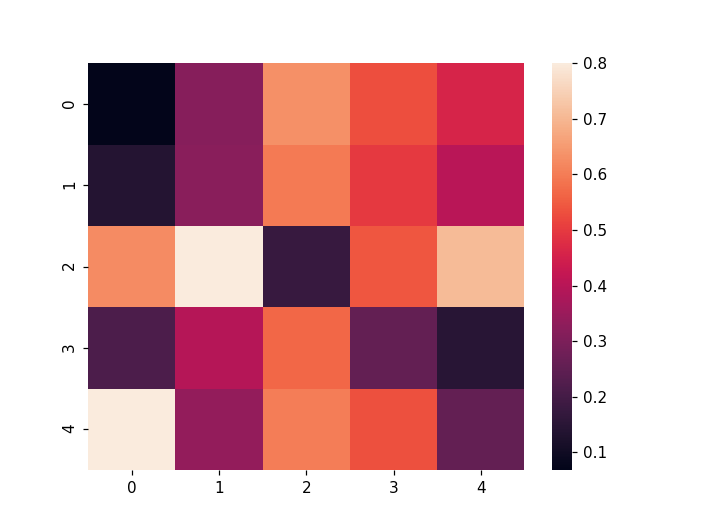

In [110]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


fig = plt.figure()
dimension = (5, 5)
data = np.random.rand(dimension[0], dimension[1])
sns.heatmap(data, vmax=.8)

def init():
    sns.heatmap(np.zeros(dimension), vmax=.8, cbar=False)

def animate(i):
    data = np.random.rand(dimension[0], dimension[1])
    sns.heatmap(data, vmax=.8, cbar=False)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=20, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


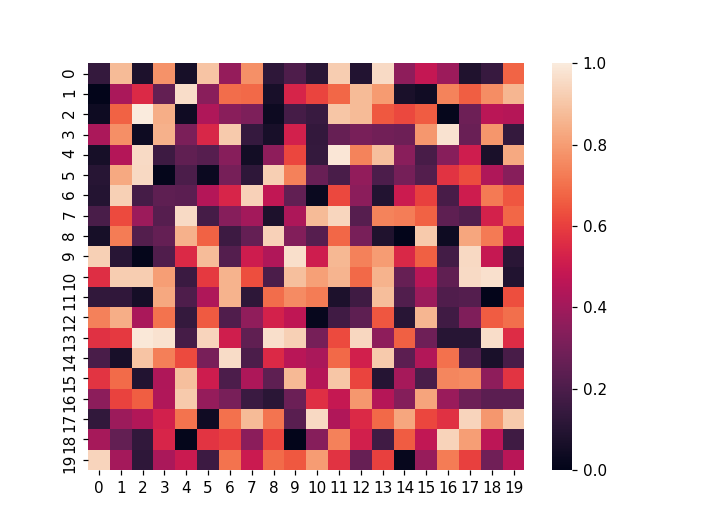

In [94]:
def animate_heat_map():
    fig = plt.figure()

    nx = ny = 20
    data = np.random.rand(nx, ny)
    ax = sns.heatmap(data, vmin=0, vmax=1)

    def init():
        plt.clf()
        ax = sns.heatmap(data, vmin=0, vmax=1)

    def animate(i):
        plt.clf()
        data = np.random.rand(nx, ny)
        ax = sns.heatmap(data, vmin=0, vmax=1)

    anim = animation.FuncAnimation(fig, animate, frames=20, init_func=init, interval=1000)

    plt.show()
    
animate_heat_map()

<IPython.core.display.Javascript object>


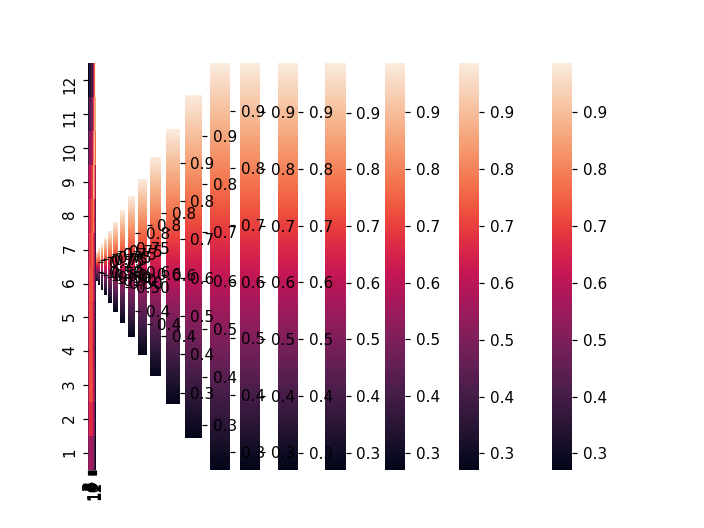

In [90]:
%matplotlib notebook
fig = plt.figure()
ani = animation.FuncAnimation(fig, animate, interval=1000,repeat=True)

In [84]:
def animate(i):
    vals = rbfs[i]
    graph = sns.heatmap(np.flip(vals, 1), xticklabels=range(1, n+1), yticklabels=range(n, 0, -1));

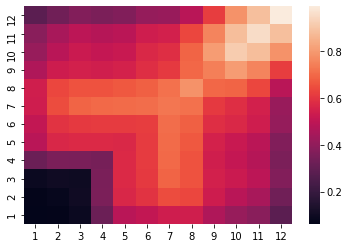

In [41]:
vals = rbf_vals
sns.heatmap(np.flip(vals, 1), xticklabels=range(1, n+1), yticklabels=range(n, 0, -1));